# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [38]:
#pip install pillow

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Importing important Libraries

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import imageio
import datetime
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import random as rn
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.optimizers import Adam

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

 ### Load and Optionally Ablate Training and Validation Data

In [3]:
def get_data(path, ablation=None):
    """
    Loads and optionally ablates training and validation data from specified paths.

    Parameters:
    path (str): The directory path where 'train.csv' and 'val.csv' are located.
    ablation (int, optional): The maximum number of samples to include per class. 
                              If None, all data is included. Defaults to None.

    Returns:
    tuple: Two lists containing the training data and validation data respectively.
    """
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [4]:
train_doc, val_doc = get_data('/home/datasets/Project_data/', ablation=None)
batch_size = 50 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 5 to 24.
seq_idx = range(5,24,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [24]:
# Define generator function
def generator(source_path, folder_list, batch_size, is_train=False, augmention=False, debug=False):
    # Create a list of image numbers you want to use for a particular video
    img_idx = seq_idx  # Define this variable appropriately
    x = len(img_idx)
    y, z = dim_x, dim_y  # Define dim_x and dim_y appropriately
    while True:
        # Doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t) % batch_size) == 0:
            num_batches = int(len(t) / batch_size)
        else:
            num_batches = len(t) // batch_size + 1
            
        for batch in range(num_batches):  # Iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # x is the number of images, (y,z) is the final size, 3 is RGB channels
            batch_labels = np.zeros((batch_size, 5))  
            for folder in range(batch_size):  # Iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20, 5))
                
                # Handling remaining datapoints
                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break
                
                folder_str = t[folder_idx]
                imgs = os.listdir(os.path.join(source_path, folder_str.split(';')[0]))  # Read all images in the folder
                
                # Randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0, 1) == 1:
                    aug_type = rn.randint(0, 4)  # Randomly selecting augmentation type
                
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image_path = os.path.join(source_path, folder_str.strip().split(';')[0], imgs[item])
                    image = Image.open(image_path).convert('RGB')
                    image = np.array(image).astype(np.float32)

                    # Plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx + 1)
                        plt.imshow(image.astype('uint8'))

                    # Crop the images and resize them
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[crop_start:crop_end, :]

                    # Resize the image using Pillow
                    image = Image.fromarray(image.astype('uint8'))
                    resized_im = image.resize((y, z))

                    # Apply augmentation if any
                    if aug_type is not None:
                        if aug_type == 0:  # Edge Enhancement
                            resized_im = resized_im.filter(ImageFilter.EDGE_ENHANCE)
                        elif aug_type == 1:  # Adding Gaussian Blur
                            resized_im = resized_im.filter(ImageFilter.GaussianBlur(1))
                        elif aug_type == 2:  # Enhancing image details
                            resized_im = resized_im.filter(ImageFilter.DETAIL)
                        elif aug_type == 3:  # Sharpening image
                            resized_im = resized_im.filter(ImageFilter.SHARPEN)
                        elif aug_type == 4:  # Brightness enhancement
                            enhancer = ImageEnhance.Brightness(resized_im)
                            resized_im = enhancer.enhance(1.5)

                    resized_im = np.array(resized_im)

                    # Plotting resized images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx + x + 1)
                        plt.imshow(resized_im)

                    # Normalize and feed in the image
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1  # Assuming labels are in the 3rd position

            yield batch_data, batch_labels  # Yield the batch_data and the batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train' 
val_path =  '/home/datasets/Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


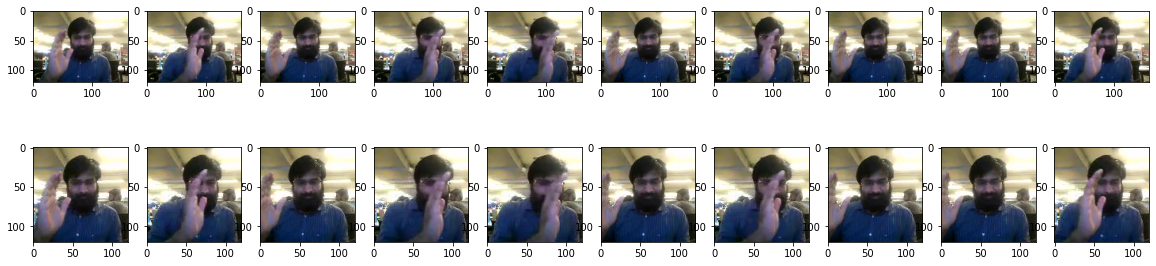

In [75]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[1]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
#input shape for the 1st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [8]:
print ('image dimension: ', dim_x, dim_y)

image dimension:  120 120


In [9]:
print ('epochs: ', num_epochs)

epochs:  50


In [10]:
print ('batch size: ', batch_size)

batch size:  50


In [14]:
print ('frames: ', len(seq_idx))

frames:  10


# Model Number - 1 
## Conv3D (batch size:  32, image dimension:  120 X 120, epochs:  10)

In [80]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [191]:
# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Assuming `model` is your defined Keras model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 8, 68, 68, 32)     2624      
                                                                 
 conv3d_23 (Conv3D)          (None, 6, 66, 66, 64)     55360     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 3, 33, 33, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 3, 33, 33, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 3, 33, 33, 64)     0         
                                                                 
 conv3d_24 (Conv3D)          (None, 1, 31, 31, 128)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [192]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [193]:
model_name = 'model_init_exp_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [194]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [128]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 2.3222 - categorical_accuracy: 0.3095
Epoch 00001: saving model to model_init_exp_1_2024-07-0108_17_28.164604/model-00001-2.32216-0.30952-705.30328-0.17188.h5
21/21 [==============================] - 29s 1s/step - loss: 2.3222 - categorical_accuracy: 0.3095 - val_loss: 705.3033 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.8078 - categorical_accuracy: 0.3616
Epoch 00002: saving model to model_init_exp_1_2024-07-0108_17_28.164604/model-00002-1.80779-0.36161-321.85382-0.19531.h5
21/21 [==============================] - 25s 1s/step - loss: 1.8078 - categorical_accuracy: 0.3616 - val_loss: 321.8538 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.5971 - categorical_accuracy: 0.4152
Epoch 00003: saving model to model_init_exp_1_2024-07-0108_17_28.164604/model-00003-1.59709-0.41518-68.3

### Plotting Model Loss and Accuracy Over Epochs

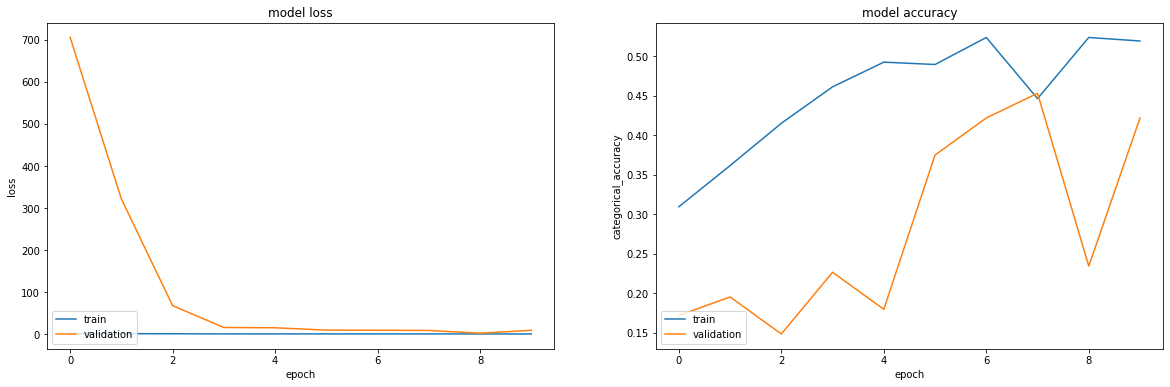

In [129]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model Number - 2
## Conv3D (batch size:  50, image dimension:  120 X 120, epochs:  10)

In [149]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.6553 - categorical_accuracy: 0.3286
Epoch 00001: saving model to model_init_exp_2_2024-07-0109_04_31.146287/model-00001-1.65532-0.32857-407.73343-0.23000.h5
14/14 [==============================] - 32s 2s/step - loss: 1.6553 - categorical_accuracy: 0.3286 - val_loss: 407.7334 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.2863 - categorical_accuracy: 0.4543
Epoch 00002: saving model to model_init_exp_2_2024-07-0109_04_31.146287/model-00002-1.28629-0.45429-260.37155-0.23000.h5
14/14 [==============================] - 26s 2s/step - loss: 1.2863 - categorical_accuracy: 0.4543 - val_loss: 260.3716 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 1.3393 - categorical_accuracy: 0.4100
Epoch 00003: saving model to model_init_exp_2_2024-07-0109_04_31.146287/model-00003-1.33928-0.41000-43.3

### Plotting Model Loss and Accuracy Over Epochs

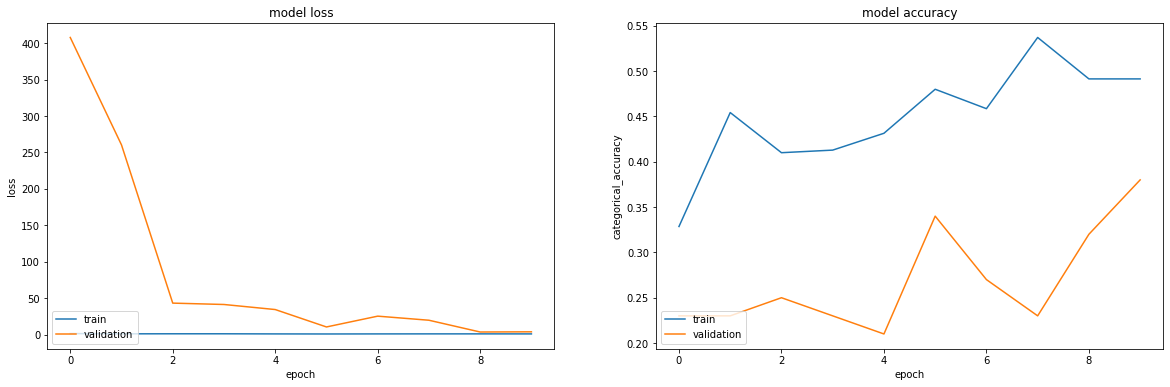

In [150]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model Number - 3
## Conv3D (batch size: 50, image dimension: 100 X 100, epochs: 10)

In [165]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 2.3464 - categorical_accuracy: 0.3343
Epoch 00001: saving model to model_init_exp_3_2024-07-0109_25_01.930027/model-00001-2.34642-0.33429-625.75317-0.22000.h5
14/14 [==============================] - 33s 2s/step - loss: 2.3464 - categorical_accuracy: 0.3343 - val_loss: 625.7532 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.4780 - categorical_accuracy: 0.3543
Epoch 00002: saving model to model_init_exp_3_2024-07-0109_25_01.930027/model-00002-1.47805-0.35429-242.91769-0.18000.h5
14/14 [==============================] - 26s 2s/step - loss: 1.4780 - categorical_accuracy: 0.3543 - val_loss: 242.9177 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 1.2851 - categorical_accuracy: 0.4386
Epoch 00003: saving model to model_init_exp_3_2024-07-0109_25_01.930027/model-00003-1.28511-0.43857-129.

# Plotting Model Loss and Accuracy Over Epochs

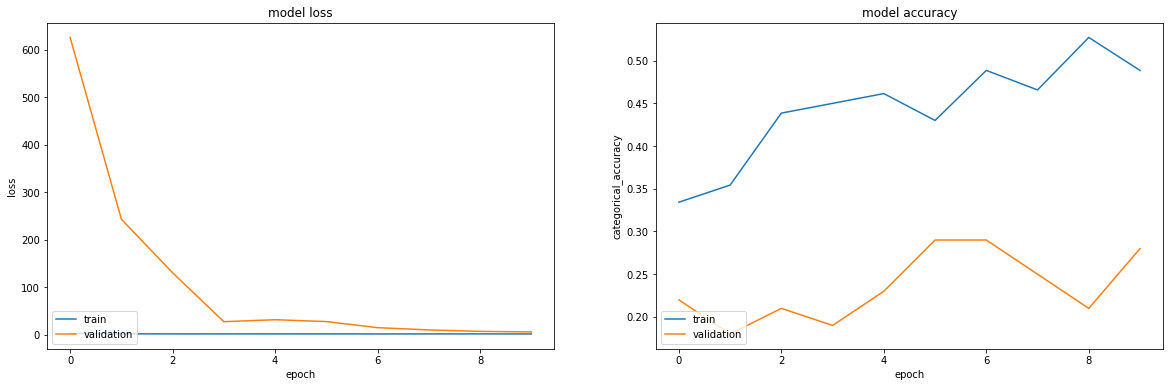

In [166]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model Number - 4
## Conv3D (batch size: 50, image dimension: 70 X 70, epochs: 10)

In [180]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 2.3545 - categorical_accuracy: 0.3129
Epoch 00001: saving model to model_init_exp_4_2024-07-0109_33_33.389783/model-00001-2.35448-0.31286-1216.09448-0.23000.h5
14/14 [==============================] - 24s 2s/step - loss: 2.3545 - categorical_accuracy: 0.3129 - val_loss: 1216.0945 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.4527 - categorical_accuracy: 0.3943
Epoch 00002: saving model to model_init_exp_4_2024-07-0109_33_33.389783/model-00002-1.45265-0.39429-197.18336-0.16000.h5
14/14 [==============================] - 23s 2s/step - loss: 1.4527 - categorical_accuracy: 0.3943 - val_loss: 197.1834 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 1.5672 - categorical_accuracy: 0.4029
Epoch 00003: saving model to model_init_exp_4_2024-07-0109_33_33.389783/model-00003-1.56718-0.40286-21

### Plotting Model Loss and Accuracy Over Epochs

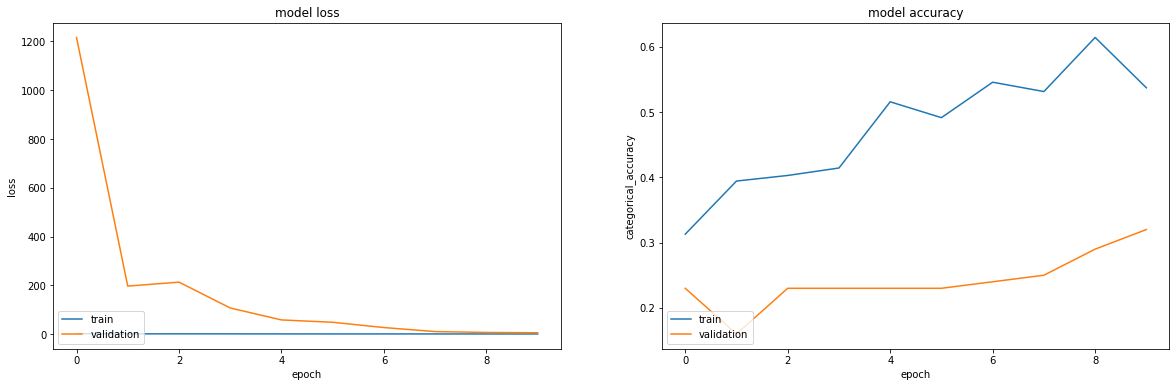

In [181]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model Number - 5
## Conv3D (batch size: 50, image dimension: 70 X 70, epochs: 50)

In [195]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 2.3670 - categorical_accuracy: 0.2829
Epoch 00001: saving model to model_init_exp_5_2024-07-0109_43_29.235993/model-00001-2.36700-0.28286-1391.89624-0.23000.h5
14/14 [==============================] - 23s 2s/step - loss: 2.3670 - categorical_accuracy: 0.2829 - val_loss: 1391.8962 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.4240 - categorical_accuracy: 0.3586
Epoch 00002: saving model to model_init_exp_5_2024-07-0109_43_29.235993/model-00002-1.42399-0.35857-406.76434-0.35000.h5
14/14 [==============================] - 22s 2s/step - loss: 1.4240 - categorical_accuracy: 0.3586 - val_loss: 406.7643 - val_categorical_accuracy: 0.3500 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.3446 - categorical_accuracy: 0.4600
Epoch 00003: saving model to model_init_exp_5_2024-07-0109_43_29.235993/model-00003-1.34462-0.46000-29

# Model Number - 6
## TimeDistributed Conv2D + GRU (batch size: 50, image dimension: 70 X 70, epochs: 50)

In [198]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [199]:
from tensorflow.keras.optimizers import Adam

# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Assuming `model` is your defined Keras model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 10, 68, 68, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 10, 34, 34, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_36 (Bat  (None, 10, 34, 34, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 10, 34, 34, 32)    0         
                                                                 
 time_distributed_11 (TimeDi  (None, 10, 32, 32, 64)   18496     
 stributed)                                          

In [200]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [201]:
model_name = 'model_init_exp_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [202]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [203]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.7390 - categorical_accuracy: 0.3586
Epoch 00001: saving model to model_init_exp_6_2024-07-0109_43_29.235993/model-00001-1.73903-0.35857-1.91768-0.23000.h5
14/14 [==============================] - 29s 2s/step - loss: 1.7390 - categorical_accuracy: 0.3586 - val_loss: 1.9177 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.1006 - categorical_accuracy: 0.4714
Epoch 00002: saving model to model_init_exp_6_2024-07-0109_43_29.235993/model-00002-1.10059-0.47143-2.87654-0.22000.h5
14/14 [==============================] - 22s 2s/step - loss: 1.1006 - categorical_accuracy: 0.4714 - val_loss: 2.8765 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.9949 - categorical_accuracy: 0.5200
Epoch 00003: saving model to model_init_exp_6_2024-07-0109_43_29.235993/model-00003-0.99490-0.52000-2.67211-0.23

# Model Number - 7
## TimeDistributed Conv2D + GRU (batch size: 50, image dimension: 120 X 120, epochs: 50)

In [115]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [116]:
from tensorflow.keras.optimizers import Adam

# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Assuming `model` is your defined Keras model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 10, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 10, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_23 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 10, 59, 59, 32)    0         
                                                                 
 time_distributed_29 (TimeDi  (None, 10, 57, 57, 64)   18496     
 stributed)                                          

In [117]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [118]:
model_name = 'model_init_exp_11' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [119]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [120]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.8044 - categorical_accuracy: 0.3543
Epoch 00001: saving model to model_init_exp_11_2024-07-0114_23_37.424476/model-00001-1.80435-0.35429-1.74953-0.23000.h5
14/14 [==============================] - 31s 2s/step - loss: 1.8044 - categorical_accuracy: 0.3543 - val_loss: 1.7495 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.0953 - categorical_accuracy: 0.4600
Epoch 00002: saving model to model_init_exp_11_2024-07-0114_23_37.424476/model-00002-1.09533-0.46000-2.50075-0.21000.h5
14/14 [==============================] - 25s 2s/step - loss: 1.0953 - categorical_accuracy: 0.4600 - val_loss: 2.5008 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.0089 - categorical_accuracy: 0.5429
Epoch 00003: saving model to model_init_exp_11_2024-07-0114_23_37.424476/model-00003-1.00887-0.54286-3.06900-0

# Model Number - 8
## TimeDistributed Conv2D + Dense (batch size: 50, image dimension: 70 X 70, epochs: 50)

In [16]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(
     Conv2D(128, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

2024-07-01 10:52:49.402523: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-01 10:52:49.403000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [17]:
from tensorflow.keras.optimizers import Adam

# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Assuming `model` is your defined Keras model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 68, 68, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 34, 34, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 10, 34, 34, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 32, 32, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 16, 16, 64)   0

In [18]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_init_exp_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


2024-07-01 10:53:42.451628: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 1.7593 - categorical_accuracy: 0.3543
Epoch 00001: saving model to model_init_exp_7_2024-07-0110_49_56.484234/model-00001-1.75932-0.35429-13.67356-0.22000.h5
14/14 [==============================] - 34s 2s/step - loss: 1.7593 - categorical_accuracy: 0.3543 - val_loss: 13.6736 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.1996 - categorical_accuracy: 0.4657
Epoch 00002: saving model to model_init_exp_7_2024-07-0110_49_56.484234/model-00002-1.19961-0.46571-21.61214-0.25000.h5
14/14 [==============================] - 22s 2s/step - loss: 1.1996 - categorical_accuracy: 0.4657 - val_loss: 21.6121 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.0648 - categorical_accuracy: 0.5129
Epoch 00003: saving model to model_init_exp_7_2024-07-0110_49_56.484234/model-00003-1.06481-0.51286-14.46117-0.23000.h5

### Plotting Model Loss and Accuracy Over Epochs

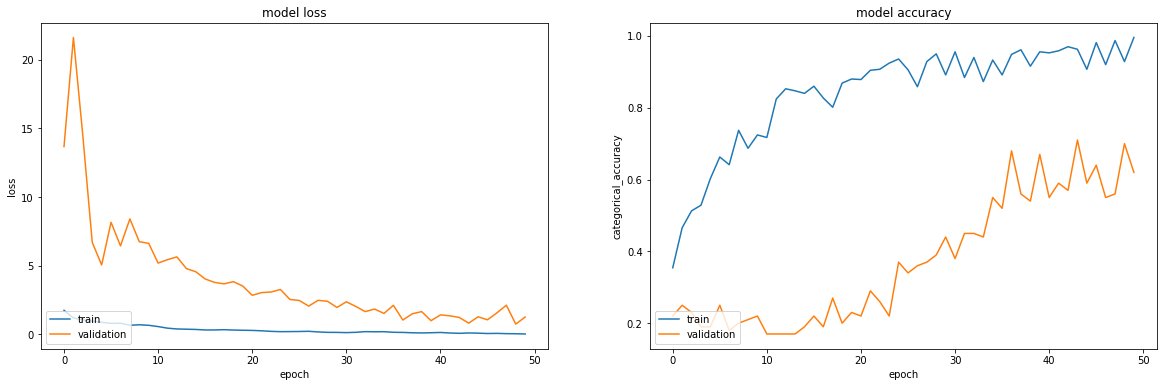

In [22]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

plt.show()

# Model Number - 9
## TimeDistributed + ConvLSTM2D (batch size: 50, image dimension: 70 X 70, epochs: 50)

In [23]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [24]:
from tensorflow.keras.optimizers import Adam

# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Assuming `model` is your defined Keras model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 68, 68, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 68, 68, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 66, 66, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 10, 66, 66, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 64, 64, 8)        

In [25]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
model_name = 'model_init_exp_8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [28]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.5158 - categorical_accuracy: 0.3400
Epoch 00001: saving model to model_init_exp_8_2024-07-0110_49_56.484234/model-00001-1.51584-0.34000-1.60052-0.26000.h5
14/14 [==============================] - 25s 2s/step - loss: 1.5158 - categorical_accuracy: 0.3400 - val_loss: 1.6005 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.3570 - categorical_accuracy: 0.3229
Epoch 00002: saving model to model_init_exp_8_2024-07-0110_49_56.484234/model-00002-1.35695-0.32286-1.74472-0.21000.h5
14/14 [==============================] - 22s 2s/step - loss: 1.3570 - categorical_accuracy: 0.3229 - val_loss: 1.7447 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.1788 - categorical_accuracy: 0.3986
Epoch 00003: saving model to model_init_exp_8_2024-07-0110_49_56.484234/model-00003-1.17876-0.39857-1.63536-0.23

### Plotting Model Loss and Accuracy Over Epochs

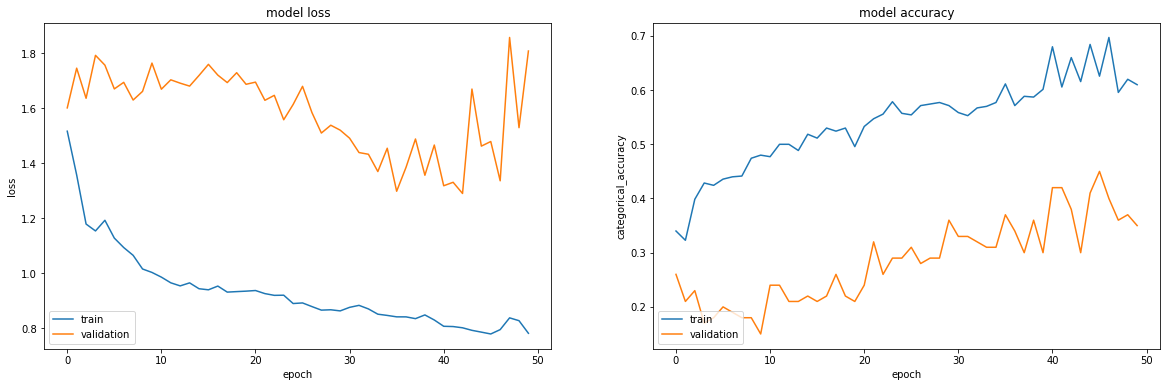

In [29]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

plt.show()

# Model Number - 10
### TimeDistributed + ConvLSTM2D (batch size: 50, image dimension: 120 X 120, epochs: 50)

In [108]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [109]:
from tensorflow.keras.optimizers import Adam

# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Assuming `model` is your defined Keras model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 10, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 10, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_20 (Bat  (None, 10, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 114, 114, 8)     

In [110]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [111]:
model_name = 'model_init_exp_10' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [112]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [113]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.4810 - categorical_accuracy: 0.3257
Epoch 00001: saving model to model_init_exp_10_2024-07-0114_23_37.424476/model-00001-1.48101-0.32571-1.83203-0.18000.h5
14/14 [==============================] - 29s 2s/step - loss: 1.4810 - categorical_accuracy: 0.3257 - val_loss: 1.8320 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.2441 - categorical_accuracy: 0.4114
Epoch 00002: saving model to model_init_exp_10_2024-07-0114_23_37.424476/model-00002-1.24412-0.41143-1.79262-0.25000.h5
14/14 [==============================] - 26s 2s/step - loss: 1.2441 - categorical_accuracy: 0.4114 - val_loss: 1.7926 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.1550 - categorical_accuracy: 0.4571
Epoch 00003: saving model to model_init_exp_10_2024-07-0114_23_37.424476/model-00003-1.15502-0.45714-1.99237-0

### Plotting Model Loss and Accuracy Over Epochs

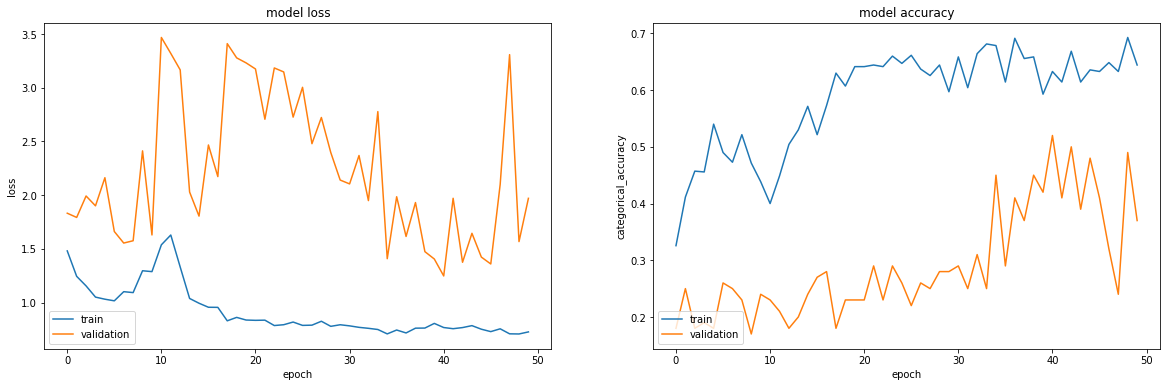

In [114]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

plt.show()

# Model Number - 11
## Transfer Learning using VGG16 (batch size: 50, image dimension: 120 X 120, epochs: 50)

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, Dense, Flatten, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [19]:
# Define the input shape
num_frames = 10  # Modify based on your specific data
img_height = 120  # Modify based on your specific data
img_width = 120  # Modify based on your specific data
num_channels = 3  # Modify based on your specific data
input_shape = (num_frames, img_height, img_width, num_channels)

In [20]:
# Load the VGG16 model pre-trained on ImageNet without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

# Make the base model layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Create a new model and add TimeDistributed wrapper for the base model
model = Sequential()
model.add(TimeDistributed(base_model, input_shape=input_shape))

# Add TimeDistributed GlobalAveragePooling2D
model.add(TimeDistributed(GlobalAveragePooling2D()))

# Flatten the output
model.add(TimeDistributed(Flatten()))

# Add your custom layers
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

# Pool across time steps
model.add(GlobalAveragePooling1D())

# Add final Dense layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [22]:
# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 10, 3, 3, 512)    14714688  
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 10, 512)          0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 10, 512)          0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 256)          131328    
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 256)         

In [25]:
train_generator = generator(train_path, train_doc, batch_size, is_train=True, augmention=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
# Define model name and checkpoints
model_name = 'model_init_exp_12' + '_' + str(datetime.now()).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [27]:
# Calculate steps per epoch
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [28]:
# Train the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/50


2024-07-02 05:28:10.634185: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 1.6143 - categorical_accuracy: 0.4729
Epoch 00001: saving model to model_init_exp_12_2024-07-0205_27_40.085286/model-00001-1.61426-0.47286-2.53703-0.28000.h5
14/14 [==============================] - 60s 4s/step - loss: 1.6143 - categorical_accuracy: 0.4729 - val_loss: 2.5370 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.6458 - categorical_accuracy: 0.7657
Epoch 00002: saving model to model_init_exp_12_2024-07-0205_27_40.085286/model-00002-0.64576-0.76571-8.14407-0.27000.h5
14/14 [==============================] - 33s 3s/step - loss: 0.6458 - categorical_accuracy: 0.7657 - val_loss: 8.1441 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.4004 - categorical_accuracy: 0.8014
Epoch 00003: saving model to model_init_exp_12_2024-07-0205_27_40.085286/model-00003-0.40037-0.80143-1.49957-0.52000.h5
1

### Plotting Model Loss and Accuracy Over Epochs

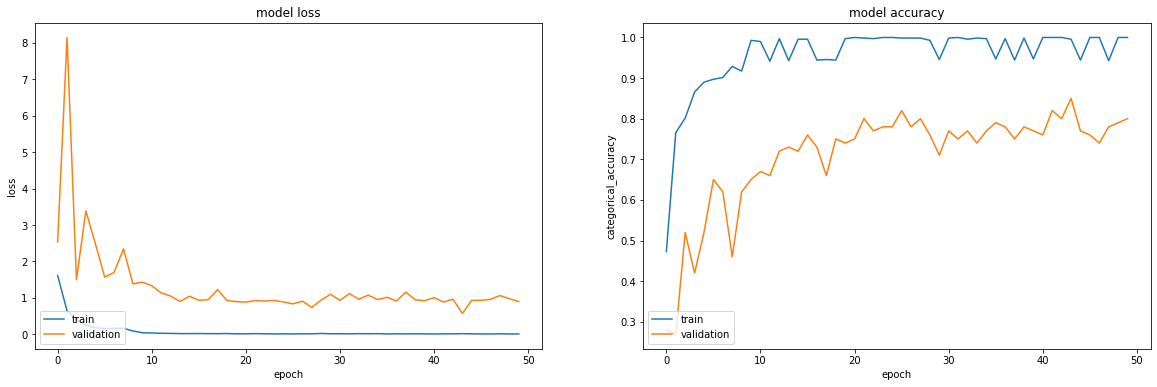

In [29]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

plt.show()

# Model Number - 12
## Transfer Learning using ResNet50 (batch size: 50, image dimension: 120 X 120, epochs: 50)

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, Dense, Flatten, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [31]:
# Define the input shape
num_frames = 10  # Modify based on your specific data
img_height = 120  # Modify based on your specific data
img_width = 120  # Modify based on your specific data
num_channels = 3  # Modify based on your specific data
input_shape = (num_frames, img_height, img_width, num_channels)

In [32]:
# Load the ResNet50 model pre-trained on ImageNet without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

# Make the base model layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 6s 0us/step


In [33]:
# Create a new model and add TimeDistributed wrapper for the base model
model = Sequential()
model.add(TimeDistributed(base_model, input_shape=input_shape))

# Add TimeDistributed GlobalAveragePooling2D
model.add(TimeDistributed(GlobalAveragePooling2D()))

# Flatten the output
model.add(TimeDistributed(Flatten()))

# Add your custom layers
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

# Pool across time steps
model.add(GlobalAveragePooling1D())

# Add final Dense layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

In [34]:
model.add(Dense(5, activation='softmax'))

# Initialize the optimizer
optimiser = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 10, 4, 4, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 10, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 10, 2048)         0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 10, 256)          524544    
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 256)         

In [35]:
# Assuming train_generator and val_generator are defined
train_generator = generator(train_path, train_doc, batch_size, is_train=True, augmention=enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
# Define model name and checkpoints
model_name = 'model_init_exp_13' + '_' + str(datetime.now()).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [37]:
# Calculate steps per epoch
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [38]:
# Train the model
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 1.7440 - categorical_accuracy: 0.3771
Epoch 00001: saving model to model_init_exp_13_2024-07-0206_08_28.635684/model-00001-1.74404-0.37714-3.63118-0.18000.h5
14/14 [==============================] - 30s 2s/step - loss: 1.7440 - categorical_accuracy: 0.3771 - val_loss: 3.6312 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.2337 - categorical_accuracy: 0.4814
Epoch 00002: saving model to model_init_exp_13_2024-07-0206_08_28.635684/model-00002-1.23366-0.48143-2.74630-0.20000.h5
14/14 [==============================] - 24s 2s/step - loss: 1.2337 - categorical_accuracy: 0.4814 - val_loss: 2.7463 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.0152 - categorical_accuracy: 0.5771
Epoch 00003: saving model to model_init_exp_13_2024-07-0206_08_28.635684/model-00003-1.01519-0.57714-3.62054-0

### Plotting Model Loss and Accuracy Over Epochs

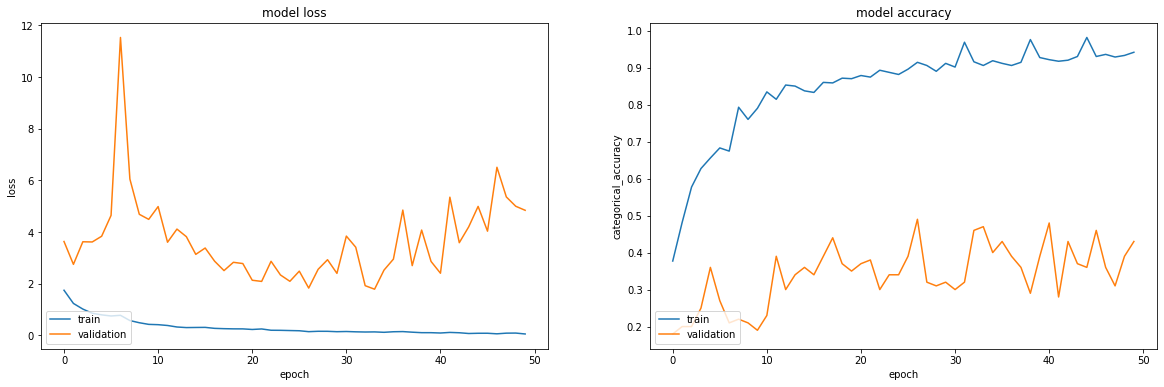

In [39]:
plt.figure(figsize=(20,6))

# Plotting model loss
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

# Plotting model accuracy
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

plt.show()